In [152]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree as treeplt
from sklearn.datasets import make_classification, make_blobs, make_regression
from sklearn.tree import DecisionTreeClassifier, plot_tree, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import make_pipeline



RANDOM_STATE: int = 54

# <font color = 'red'> ЛР 6. Дерево решений. Метрики f1 качества классификации. </font>

Сложность: <font color = 'green'> Легко  </font>.

Дата составления: 07.10.2024

Срок выполнения: 2 недели (с момента первой практики после выдачи).

Автор: ст. преподаватель Кушнеров А.В.

## <font color = 'green'> 1. Энтропия.  </font>

**Энтропия Шеннона** - мера хаотичности множества. Пусть задано множество из $N$ представителей $s$ различных классов. $X = (x_{1},x_{1},x_{1},...,x_{2},x_{2},...,...x_{s},x_{s},...)$.

Энтропия тогда может быть вычислена по формуле:

$$S(X)=-\displaystyle\sum_{i=1}^{s} p_{i}\log_2 p_{i}$$

Где, $p_{i}=N_{i}/N$.

<font color = 'red' size = 5>Задание 1 </font>

Реализуйте функцию для подсчёта энтропии Шеннонна для заданной выборки. Сравните результат работы со встроенной функцией.


[Справочная информация](https://ru.wikipedia.org/wiki/%D0%98%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%B0%D1%8F_%D1%8D%D0%BD%D1%82%D1%80%D0%BE%D0%BF%D0%B8%D1%8F)


In [8]:
test = np.random.randint(0,3,100)
test

unique, counts = np.unique(test, return_counts=True)

In [9]:
print(test)
print(unique)
print(counts)

[2 1 0 1 1 1 1 0 1 2 2 1 1 1 2 2 2 2 1 1 2 2 0 0 1 0 1 1 0 0 0 2 0 1 1 2 1
 2 0 1 0 2 1 0 1 2 2 2 2 2 2 2 0 0 2 0 0 0 0 0 0 2 1 0 1 0 0 0 1 1 0 2 0 0
 0 2 2 0 0 2 2 2 0 2 0 1 2 1 1 0 2 2 2 1 1 0 2 0 2 2]
[0 1 2]
[35 29 36]


In [10]:
entropy(counts,base=2)

np.float64(1.578619644737758)

In [159]:
def shannon_entropy(data):
    # Считаем частоты значений в выборке
    counts = Counter(data)
    total = sum(counts.values())  # Общее количество элементов
    
    # Вычисляем вероятности для каждого уникального значения
    probabilities = [count / total for count in counts.values()]
    
    # Вычисляем энтропию по формуле Шеннона
    entropy_value = -sum(p * np.log2(p) for p in probabilities if p > 0)
    return entropy_value

# наш слон
manual_entropy = shannon_entropy(test)
print(f"Custom entropy: {manual_entropy}")

# встроенный слоняра
value_counts = np.array(list(Counter(test).values()))
scipy_entropy = entropy(value_counts, base=2)
print(f"Entropy from scipy: {scipy_entropy}")

Custom entropy: 1.5786196447377578
Entropy from scipy: 1.578619644737758


## <font color = 'green'> 2. Прирост информации и дерево принятия решений  </font>

Пусть исходное множество $X$ было разделено на несколько подмножеств (чаще всего на 2). В каждом из них можем посчитать энтропию. Мы ожидаем, что наше разбиение уменьшит энтропию в каждом из подмножеств или в целом, что должно приблизить нас к решению задачи классификации. Для того, чтобы получить полную картину вводят понятие прироста информации.

$$IG(Q) = S_{0}-\displaystyle\sum_{i=1}^{q} \frac{N_{i}}{N}S_{i}$$

Тут имеем: $S_{0}$ - энтропия исходного множества, $N_{i}$ - количесвто элементов в каждом новом классе после разбиения, $N$ - исходное количество элементов, $q$ - количество множеств после разбиения,  $S_{i}$ - энтропия новых множеств.


Суть работы решающего дерева в разделении обучающего множества на подмножества, так чтобы энтропия выборки меток уменьшалась по каждому подмножеству, а прирост информации увеличивался. В качестве критерия для разделения(по признакам) выбирают тот, который даёт наибольший прирост информации (по меткам). Эта процедура повторяется рекурсивно.

[Справочная информация](https://scikit-learn.org/stable/modules/tree.html#tree)

<font color = 'red' size = 5>Задание 2 </font>


1. Реализуйте учебное приложение, которое строит решающее дерево на основе энтропии классификации на данных состоящих не более чем из двух признаков.
2. Проверьте своё приложение на простых искусственных данных и сравните со встроенным классом DecisionTreeClassifier.
3. Реализуйте учебное приложение, которое строит решающее дерево на основе критерия Джини классификации на данных состоящих не более чем из двух признаков.*

In [160]:
def gini(y):
    counts = np.bincount(y)
    probabilities = counts / len(y)
    return 1 - np.sum([p ** 2 for p in probabilities])

def information_gain(y, y_left, y_right, criterion):
    if criterion == "entropy":
        parent_loss = entropy(y)
        left_loss = entropy(y_left)
        right_loss = entropy(y_right)
    elif criterion == "gini":
        parent_loss = gini(y)
        left_loss = gini(y_left)
        right_loss = gini(y_right)
    else:
        raise ValueError("Criterion must be 'entropy' or 'gini'")

    weight_left = len(y_left) / len(y)
    weight_right = len(y_right) / len(y)
    return parent_loss - (weight_left * left_loss + weight_right * right_loss)

In [161]:
class Custom_Decision_Tree:
    def __init__(self, max_depth=3, criterion="entropy"):
        self.max_depth = max_depth
        self.criterion = criterion  # entropy или gini
        self.tree = None
    
    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)
    
    def _best_split(self, X, y):
        best_gain = 0
        best_split = None
        n_features = X.shape[1]
        
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_idx = X[:, feature] <= threshold
                right_idx = X[:, feature] > threshold
                if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
                    continue
                gain = information_gain(y, y[left_idx], y[right_idx], self.criterion)
                if gain > best_gain:
                    best_gain = gain
                    best_split = {"feature": feature, "threshold": threshold, 
                                  "left_idx": left_idx, "right_idx": right_idx}
        return best_gain, best_split
    
    def _build_tree(self, X, y, depth):
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            return Counter(y).most_common(1)[0][0]
        
        gain, split = self._best_split(X, y)
        if not split:
            return Counter(y).most_common(1)[0][0]
        
        left = self._build_tree(X[split["left_idx"]], y[split["left_idx"]], depth + 1)
        right = self._build_tree(X[split["right_idx"]], y[split["right_idx"]], depth + 1)
        
        return {"feature": split["feature"], "threshold": split["threshold"], 
                "left": left, "right": right}
    
    def predict_sample(self, node, sample):
        if isinstance(node, (int, np.integer)):
            return node
        if sample[node["feature"]] <= node["threshold"]:
            return self.predict_sample(node["left"], sample)
        return self.predict_sample(node["right"], sample)
    
    def predict(self, X):
        return np.array([self.predict_sample(self.tree, sample) for sample in X])

НА ОСНОВЕ ЭНТРОПИИ

In [162]:
# Генерация данных
X, y = make_blobs(n_samples=400, centers=4, cluster_std=1.3, random_state=RANDOM_STATE)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [163]:
# Обучение кастомного дерева
custom_tree = Custom_Decision_Tree(criterion="entropy", max_depth=3)
custom_tree.fit(X_train, y_train)
y_pred_custom = custom_tree.predict(X_test)

# Обучение встроенного дерева из sklearn
sklearn_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=RANDOM_STATE)
sklearn_tree.fit(X_train, y_train)
y_pred_sklearn = sklearn_tree.predict(X_test)

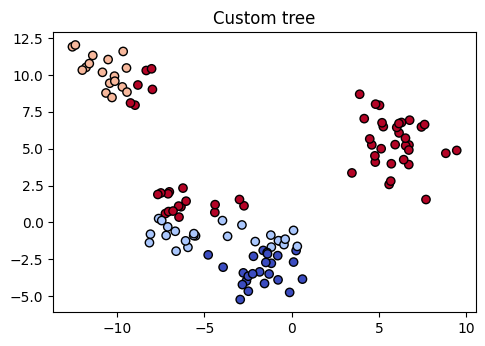

In [165]:
# Визуализация результатов
plt.figure(figsize=(12, 8))

# Кастомное дерево на тестовой выборке
plt.subplot(2, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_custom, cmap='coolwarm', edgecolors='k')
plt.title("Custom tree")
plt.show()

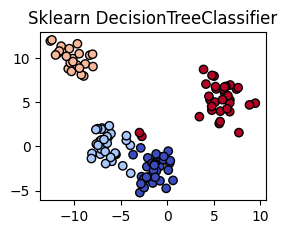

In [166]:
# Встроенное дерево на тестовой выборке
plt.subplot(2, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_sklearn, cmap='coolwarm', edgecolors='k')
plt.title("Sklearn DecisionTreeClassifier")
plt.show()

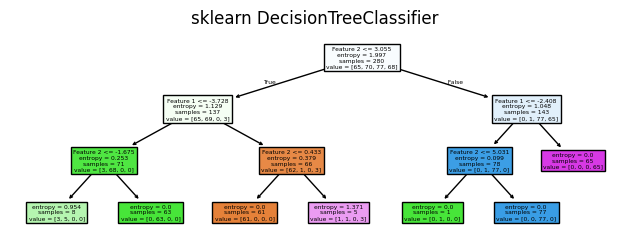

In [167]:
# Визуализация структуры sklearn дерева
plt.subplot(2, 1, 2)
plot_tree(sklearn_tree, feature_names=["Feature 1", "Feature 2"], filled=True)
plt.title("sklearn DecisionTreeClassifier")

plt.tight_layout()
plt.show()

НА ОСНОВЕ ДЖИНИ

In [61]:
# Обучение кастомного дерева
custom_tree = Custom_Decision_Tree(criterion="gini", max_depth=3)
custom_tree.fit(X_train, y_train)
y_pred_custom = custom_tree.predict(X_test)

# Обучение встроенного дерева из sklearn
sklearn_tree = DecisionTreeClassifier(criterion="gini", max_depth=3, random_state=RANDOM_STATE)
sklearn_tree.fit(X_train, y_train)
y_pred_sklearn = sklearn_tree.predict(X_test)

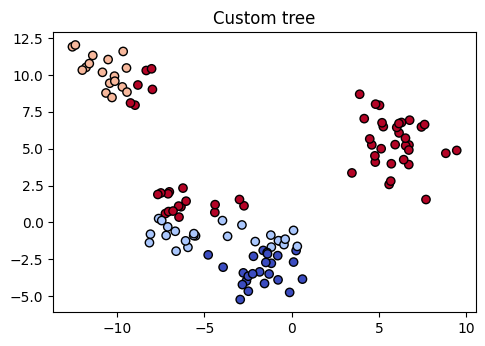

In [168]:
# Визуализация результатов
plt.figure(figsize=(12, 8))

# Кастомное дерево на тестовой выборке
plt.subplot(2, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_custom, cmap='coolwarm', edgecolors='k')
plt.title("Custom tree")
plt.show()

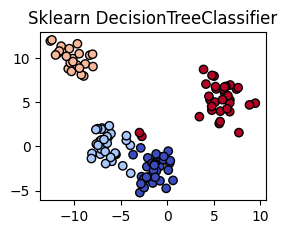

In [169]:
# Встроенное дерево на тестовой выборке
plt.subplot(2, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_sklearn, cmap='coolwarm', edgecolors='k')
plt.title("Sklearn DecisionTreeClassifier")
plt.show()

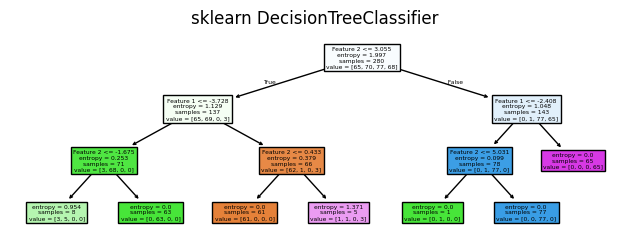

In [170]:
# Визуализация структуры sklearn дерева
plt.subplot(2, 1, 2)
plot_tree(sklearn_tree, feature_names=["Feature 1", "Feature 2"], filled=True)
plt.title("sklearn DecisionTreeClassifier")

plt.tight_layout()
plt.show()

<font color = 'red' size = 5>Задание 3 </font>

Для каждого из подзаданий:

1. Проведите предварительную обработку данных.
2. Постройте модель классификации на основе метода решающего дерева из встроенной библиотеки. 
3. Подберите оптимальные гиперпараметры модели используя различные оценки, кросс-валидацию и валидационные кривые.
4. Сделайте выводы о точности моделей.
5. Продумайте, как дерево может бороться с переобучением. Подвердите валидационными кривыми. 
6. Оцените качество модели с помощью precision\recall score.

(https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)



##### 3.1 Самый известный датасет в мире.

Используйте данные из сэта о [титанике](https://www.kaggle.com/c/titanic) для предсказания выживания. 
Предврительно изучите и подготовьте данные.

#####  3.2 Предсказание диабета у пациентов.

Используйте данные из файла [diabetes.csv](https://www.kaggle.com/datasets/saurabh00007/diabetescsv) для предсказания исхода для пациентов. Столбец "outcome". Предварительно изучите и подготовьте данные. 


##### 3.3 Данные о цветках ириса

[IrisDataset](https://www.kaggle.com/datasets/uciml/iris)

##### 3.4 Грибы

Попробуйте предсказать съедобность гриба с помощью дерева принятия решений.
[mushrooms](https://www.kaggle.com/datasets/uciml/mushroom-classification/code)



In [71]:
def scale_data(data, column):
    scaler = StandardScaler()
    data[column] = scaler.fit_transform(data[column].values.reshape(-1, 1)).flatten()
    return data

def remove_outliers_by_zscore(data, column):    
    cr_mean = np.nanmean(data[column].values)
    cr_std = np.nanstd(data[column].values)

    data['Zscore_' + column] = (data[column] - cr_mean) / cr_std

    z_3 = (3 * cr_std) + cr_mean
    z_minus3 = cr_mean - (3 * cr_std)

    data.loc[data['Zscore_' + column] > 3, column] = z_3
    data.loc[data['Zscore_' + column] < -3, column] = z_minus3

    return data

<h1>3.1</h1>

In [96]:
titanic=pd.read_csv('newTrain.csv').dropna()
titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,-0.530377,1,0,-0.502445,0,1,0,0,1
1,1,1,0.571831,1,0,0.786845,1,0,1,0,0
2,1,3,-0.254825,0,0,-0.488854,1,0,0,0,1
3,1,1,0.365167,1,0,0.420730,1,0,0,0,1
4,0,3,0.365167,0,0,-0.486337,0,1,0,0,1


In [97]:
X= titanic.drop(['Survived'],axis=True).values
y=titanic['Survived']
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=RANDOM_STATE)

0.7767441860465116


<Axes: >

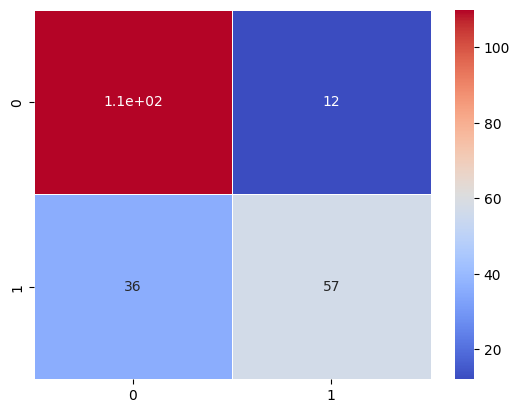

In [98]:
tree= DecisionTreeClassifier(criterion='entropy', max_depth=7)
tree.fit(Xtrain,ytrain)
ypred=tree.predict(Xtest)
print(accuracy_score(ytest, ypred))

confusion = confusion_matrix(ytest,ypred)
sns.heatmap(confusion, annot=True, cmap='coolwarm', linewidths=0.5)

0.8054773082942097


<Axes: >

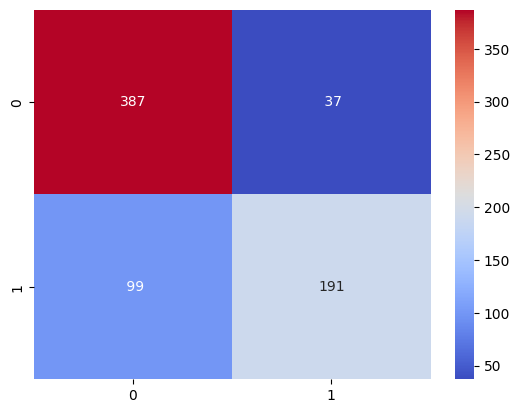

In [99]:
result_tree=cross_val_score(tree,X,y,cv=10,scoring='accuracy')
print(result_tree.mean())
y_pred = cross_val_predict(tree,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="coolwarm")

<h1>3.2</h1>

In [100]:
diabetes=pd.read_csv('newDiabetes.csv').dropna()
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Zscore_Glucose,Zscore_BloodPressure,Zscore_SkinThickness,Zscore_Insulin,Zscore_BMI,Zscore_DiabetesPedigreeFunction,Zscore_Age
0,6,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995,1,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,1,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672,0,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,8,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584,1,1.943724,-0.263941,-1.288212,-0.692891,-1.103255,0.604397,-0.105584
3,1,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549,0,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,0,0.504055,-1.504687,0.907270,0.765836,1.409746,3.000000,-0.020496,1,0.504055,-1.504687,0.907270,0.765836,1.409746,5.484909,-0.020496


In [101]:
undersample = RandomUnderSampler(sampling_strategy='majority',random_state=RANDOM_STATE)
X= diabetes.drop(['Outcome'],axis=True).values
y=diabetes['Outcome']
X,y = undersample.fit_resample(X,y)
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.4,random_state=RANDOM_STATE)

0.5395348837209303


<Axes: >

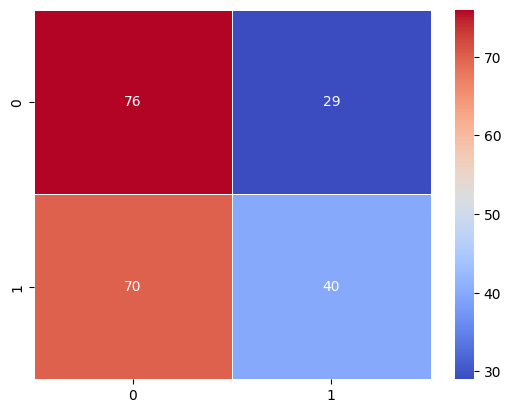

In [102]:
tree= DecisionTreeClassifier(criterion='gini', max_depth=4)
tree.fit(Xtrain,ytrain)
print(accuracy_score(ytest, ypred))

confusion = confusion_matrix(ytest,ypred)
sns.heatmap(confusion, annot=True, cmap='coolwarm', linewidths=0.5)

0.7488372093023256


<Axes: >

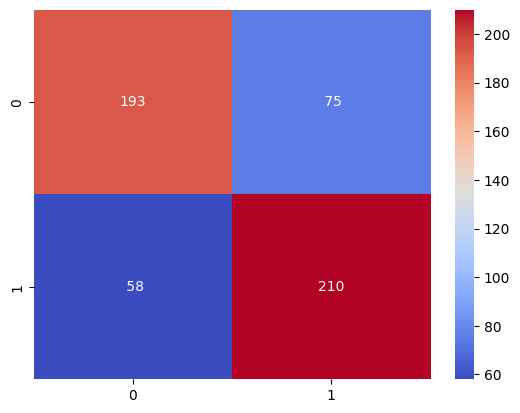

In [103]:
ypred=tree.predict(Xtest)
print(accuracy_score(ytest, ypred))
y_pred = cross_val_predict(tree,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="coolwarm")

<h1>3.3</h1>

In [104]:
iris = sns.load_dataset('iris')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [106]:
X= iris.drop(['species'],axis=True).values
y=iris['species']
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=RANDOM_STATE)

0.9111111111111111


<Axes: >

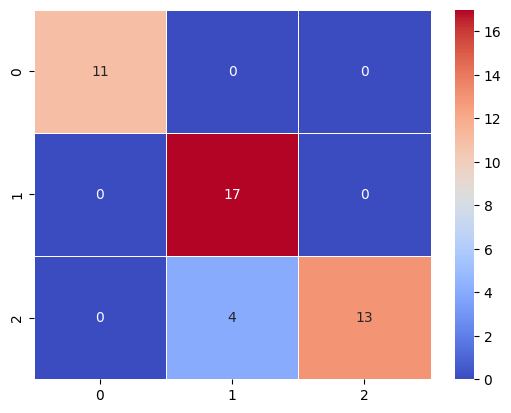

In [107]:
tree= DecisionTreeClassifier(criterion='entropy', max_depth=7)
tree.fit(Xtrain,ytrain)
ypred=tree.predict(Xtest)
print(accuracy_score(ytest, ypred))

confusion = confusion_matrix(ytest,ypred)
sns.heatmap(confusion, annot=True, cmap='coolwarm', linewidths=0.5)

0.9111111111111111


<Axes: >

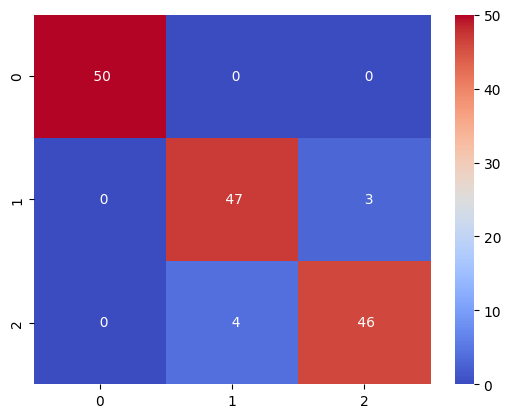

In [108]:
ypred=tree.predict(Xtest)
print(accuracy_score(ytest, ypred))
y_pred = cross_val_predict(tree,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="coolwarm")

<h1>3.4</h1>

In [121]:
mushroom = pd.read_csv('mushrooms.csv')
mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [122]:
mushroom = pd.get_dummies(mushroom, columns=mushroom.columns, drop_first=True)
mushroom.head()

,class_p,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,...,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,True,False,False,False,False,True,False,True,False,False,...,False,True,False,False,False,False,False,False,True,False
1,False,False,False,False,False,True,False,True,False,False,...,True,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,True,False,False,...,True,False,False,False,False,False,True,False,False,False
3,True,False,False,False,False,True,False,False,True,False,...,False,True,False,False,False,False,False,False,True,False
4,False,False,False,False,False,True,False,True,False,False,...,False,False,False,False,True,False,False,False,False,False


<p>Я решил не сохранять в новый csv а так оставить</p>

In [123]:
X = mushroom.drop(['class_p'],axis=1)
y = mushroom['class_p']
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,random_state=RANDOM_STATE)

1.0


<Axes: >

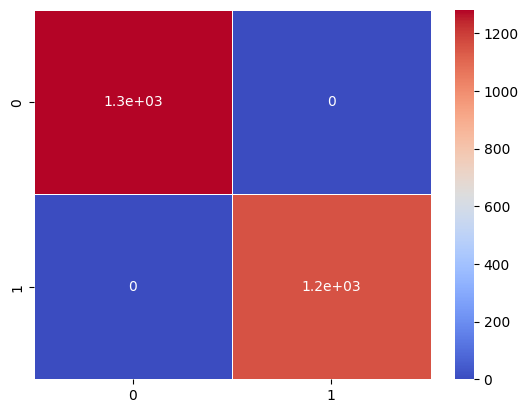

In [124]:
tree= DecisionTreeClassifier(criterion='gini', max_depth=7)
tree.fit(Xtrain,ytrain)
ypred=tree.predict(Xtest)
print(accuracy_score(ytest, ypred))

confusion = confusion_matrix(ytest,ypred)
sns.heatmap(confusion, annot=True, cmap='coolwarm', linewidths=0.5)

1.0


<Axes: >

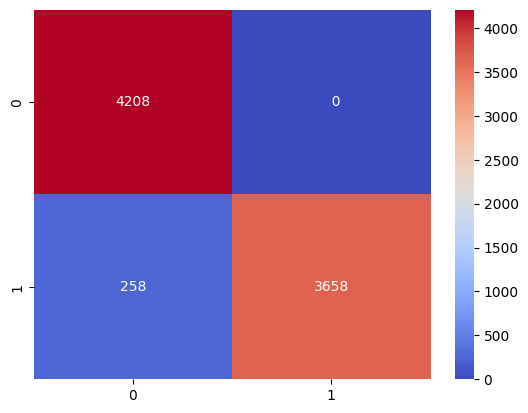

In [125]:
ypred=tree.predict(Xtest)
print(accuracy_score(ytest, ypred))
y_pred = cross_val_predict(tree,X,y,cv=10)
sns.heatmap(confusion_matrix(y,y_pred),annot=True,fmt='3.0f',cmap="coolwarm")

<font color = 'red' size = 5>Задание 4 </font>

Используя встроенные методы реализуйте регрессию с помощью решающего дерева. Примените для данных из предыдущих ЛР. Сделайте выводы. По какому принципу работает дерево в случае регресии?

In [142]:
# Класс для решения задачи регрессии с помощью решающего дерева
class CustomDecisionTreeRegressor:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None
    
    # Функция для вычисления дисперсии (используется для критерия разбиения)
    def _variance(self, y):
        return np.var(y)
    
    # Функция для нахождения лучшего разбиения
    def _best_split(self, X, y):
        best_split = None
        best_variance = float('inf')
        n_samples, n_features = X.shape
        
        for feature in range(n_features):
            # Получаем все уникальные значения для текущей особенности
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                # Разделяем данные на два подмножества
                left_idx = X[:, feature] <= threshold
                right_idx = ~left_idx
                
                # Если одно из подмножеств пустое, пропускаем это разбиение
                if np.sum(left_idx) == 0 or np.sum(right_idx) == 0:
                    continue
                
                left_variance = self._variance(y[left_idx])
                right_variance = self._variance(y[right_idx])
                
                # Общая дисперсия (взвешенная по размерам подмножеств)
                total_variance = (np.sum(left_idx) * left_variance + np.sum(right_idx) * right_variance) / n_samples
                
                if total_variance < best_variance:
                    best_variance = total_variance
                    best_split = {
                        "feature": feature,
                        "threshold": threshold,
                        "left_idx": left_idx,
                        "right_idx": right_idx
                    }
        
        return best_split
    
    # Рекурсивное построение дерева
    def _build_tree(self, X, y, depth):
        if depth >= self.max_depth or len(np.unique(y)) == 1:
            # Если глубина превышена или все значения одинаковы, возвращаем среднее значение
            return np.mean(y)
        
        split = self._best_split(X, y)
        if split is None:
            return np.mean(y)
        
        left = self._build_tree(X[split["left_idx"]], y[split["left_idx"]], depth + 1)
        right = self._build_tree(X[split["right_idx"]], y[split["right_idx"]], depth + 1)
        
        return {"feature": split["feature"], "threshold": split["threshold"], "left": left, "right": right}
    
    # Прогнозирование для одного образца
    def _predict_sample(self, node, sample):
        if isinstance(node, (int, float)):
            return node
        if sample[node["feature"]] <= node["threshold"]:
            return self._predict_sample(node["left"], sample)
        return self._predict_sample(node["right"], sample)
    
    # Прогнозирование для всех образцов
    def predict(self, X):
        return np.array([self._predict_sample(self.tree, sample) for sample in X])
    
    # Обучение модели
    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)


In [147]:
X, y = make_regression(n_samples=100, n_features=3, noise=0.1, random_state=RANDOM_STATE)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=RANDOM_STATE)

tree = CustomDecisionTreeRegressor(max_depth=7)
tree.fit(Xtrain, ytrain)

ypred = tree.predict(Xtrain)
print("R2 of model on train: "+ str(r2_score(ytrain, ypred)))

ypred = tree.predict(Xtest)
print("R2 of model on test: "+ str(r2_score(ytest, ypred)))

R2 of model on train: 0.997702479133317
R2 of model on test: 0.7733891985041783


In [148]:
tree = DecisionTreeRegressor(max_depth=7)
tree.fit(Xtrain, ytrain)

ypred = tree.predict(Xtrain)
print("R2 of model on train: "+ str(r2_score(ytrain, ypred)))

ypred = tree.predict(Xtest)
print("R2 of model on test: "+ str(r2_score(ytest, ypred)))

R2 of model on train: 0.997702479133317
R2 of model on test: 0.7153076180997449


In [156]:
housing_df = pd.read_csv('housing.csv')
housing_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [157]:
X = housing_df.drop(columns=['MEDV'])
y = housing_df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

In [158]:
tree = DecisionTreeRegressor(max_depth=8)
tree.fit(Xtrain, ytrain)
ypred = tree.predict(Xtrain)

ypred = tree.predict(Xtrain)
print("R2 of model on train: "+ str(r2_score(ytrain, ypred)))

ypred = tree.predict(Xtest)
print("R2 of model on test: "+ str(r2_score(ytest, ypred)))

R2 of model on train: 0.9996092072461363
R2 of model on test: 0.7554708805686201


<P>В отличие от классификации, где дерево принимает решение на основе категории, в регрессии дерево принимает решения на основе среднего значения целевой переменной в каждом узле.</P>